# Final Project: **Regression Analysis of German Air Fares**
by **Andre Datchev**, **Hannah Kiel**, **Hannes Pohnke**, **Nikolas Jochens**

## **1) Opening Remarks**

We don't know exactly what kind of price configurations were chosen while scraping the dataset. We are assuming that each entry is the cheapest possible configuration for the corresponding flight. So no additional baggage, no extra leg room, no business class and no other extras that would influence the price.

## **2) Setup and Dataset Cleanup**

### **2.1) Imports**

In [172]:
import pandas as pd
import matplotlib.pyplot as plt 
import datetime

### **2.2) Dataset**
We will now import our dataset. It can be found under:  [*https://www.kaggle.com/datasets/darjand/domestic-german-air-fares*](https://www.kaggle.com/datasets/darjand/domestic-german-air-fares)<br>
We renamed the csv file to *german_air_fares.csv*.

In [251]:
data = pd.read_csv("german_air_fares.csv", sep=";")
data.head()

,departure_city,arrival_city,scrape_date,departure_date,departure_date_distance,departure_time,arrival_time,airline,stops,price (€)
0,TXL Berlin-Tegel,DUS Düsseldorf,18.10.2019,18.11.2019,1 month,2:40pm,3:50pm,Eurowings,direct,33.00
1,TXL Berlin-Tegel,DUS Düsseldorf,18.10.2019,18.11.2019,1 month,1:00pm,2:15pm,Eurowings,direct,33.00
2,TXL Berlin-Tegel,DUS Düsseldorf,18.10.2019,18.11.2019,1 month,8:45pm,10:00pm,Eurowings,direct,33.00
3,TXL Berlin-Tegel,DUS Düsseldorf,18.10.2019,18.11.2019,1 month,1:05pm,2:20pm,easyJet,direct,37.00
4,TXL Berlin-Tegel,DUS Düsseldorf,18.10.2019,18.11.2019,1 month,5:30pm,6:45pm,easyJet,direct,37.00


### **2.3) Dataset Cleanup**

Problem: "1 Stopp" and "1 stop" is the same, but in two different languages. We have the same problem with "Mehrere Fluglinien" and "Multiple Airlines".

In [254]:
# set initial data types
data = data.astype('string')

# rename price column
data = data.rename(columns={'price (€)': 'price'})

# fix price column format errors
data.price = data.price.str.replace(',', '')
data.price = data.price.str.replace('.00', '')

# rename entries in airlines column
data.airline = data.airline.str.replace('Mehrere Fluglinien', 'Multiple Airlines')

# rename entries in stops column
data.stops = data.stops.str.replace('direct', '0')
data.stops = data.stops.str.replace('(1 Stopp)', '1')
data.stops = data.stops.str.replace('(1 stop)', '1')
data.stops = data.stops.str.replace('(2 Stopps)', '2')

# rename entries in departure_date_distance
data.departure_date_distance = data.departure_date_distance.str.replace('2 weeks', '2 week')
data.departure_date_distance = data.departure_date_distance.str.replace('2 week', '2 weeks')
data.departure_date_distance = data.departure_date_distance.str.replace('3 months', '3 month')
data.departure_date_distance = data.departure_date_distance.str.replace('3 month', '3 months')

# rename entries in departure_time column
data.departure_time = data.departure_time.str.replace(' Uhr', '')

# update data types
data = data.astype({'price': 'int32'})

# delete erroneous row
data = data.drop(data[data.price == data.price.max()].index)

data = data.astype({'stops': 'int32'})
data = data.astype({'scrape_date': 'datetime64[ns]'})
data = data.astype({'departure_date': 'datetime64[ns]'})
data = data.astype({'departure_time': 'datetime64[ns]'})



In [107]:
data.dtypes

departure_city             string[python]
arrival_city               string[python]
scrape_date                datetime64[ns]
departure_date             datetime64[ns]
departure_date_distance    string[python]
departure_time             datetime64[ns]
arrival_time               string[python]
airline                    string[python]
stops                               int32
price                               int32
dtype: object

In [108]:
data.head()

,departure_city,arrival_city,scrape_date,departure_date,departure_date_distance,departure_time,arrival_time,airline,stops,price
0,TXL Berlin-Tegel,DUS Düsseldorf,2019-10-18,2019-11-18,1 month,2023-11-28 14:40:00,3:50pm,Eurowings,0,33
1,TXL Berlin-Tegel,DUS Düsseldorf,2019-10-18,2019-11-18,1 month,2023-11-28 13:00:00,2:15pm,Eurowings,0,33
2,TXL Berlin-Tegel,DUS Düsseldorf,2019-10-18,2019-11-18,1 month,2023-11-28 20:45:00,10:00pm,Eurowings,0,33
3,TXL Berlin-Tegel,DUS Düsseldorf,2019-10-18,2019-11-18,1 month,2023-11-28 13:05:00,2:20pm,easyJet,0,37
4,TXL Berlin-Tegel,DUS Düsseldorf,2019-10-18,2019-11-18,1 month,2023-11-28 17:30:00,6:45pm,easyJet,0,37


## **3) Analysis of Dataset**

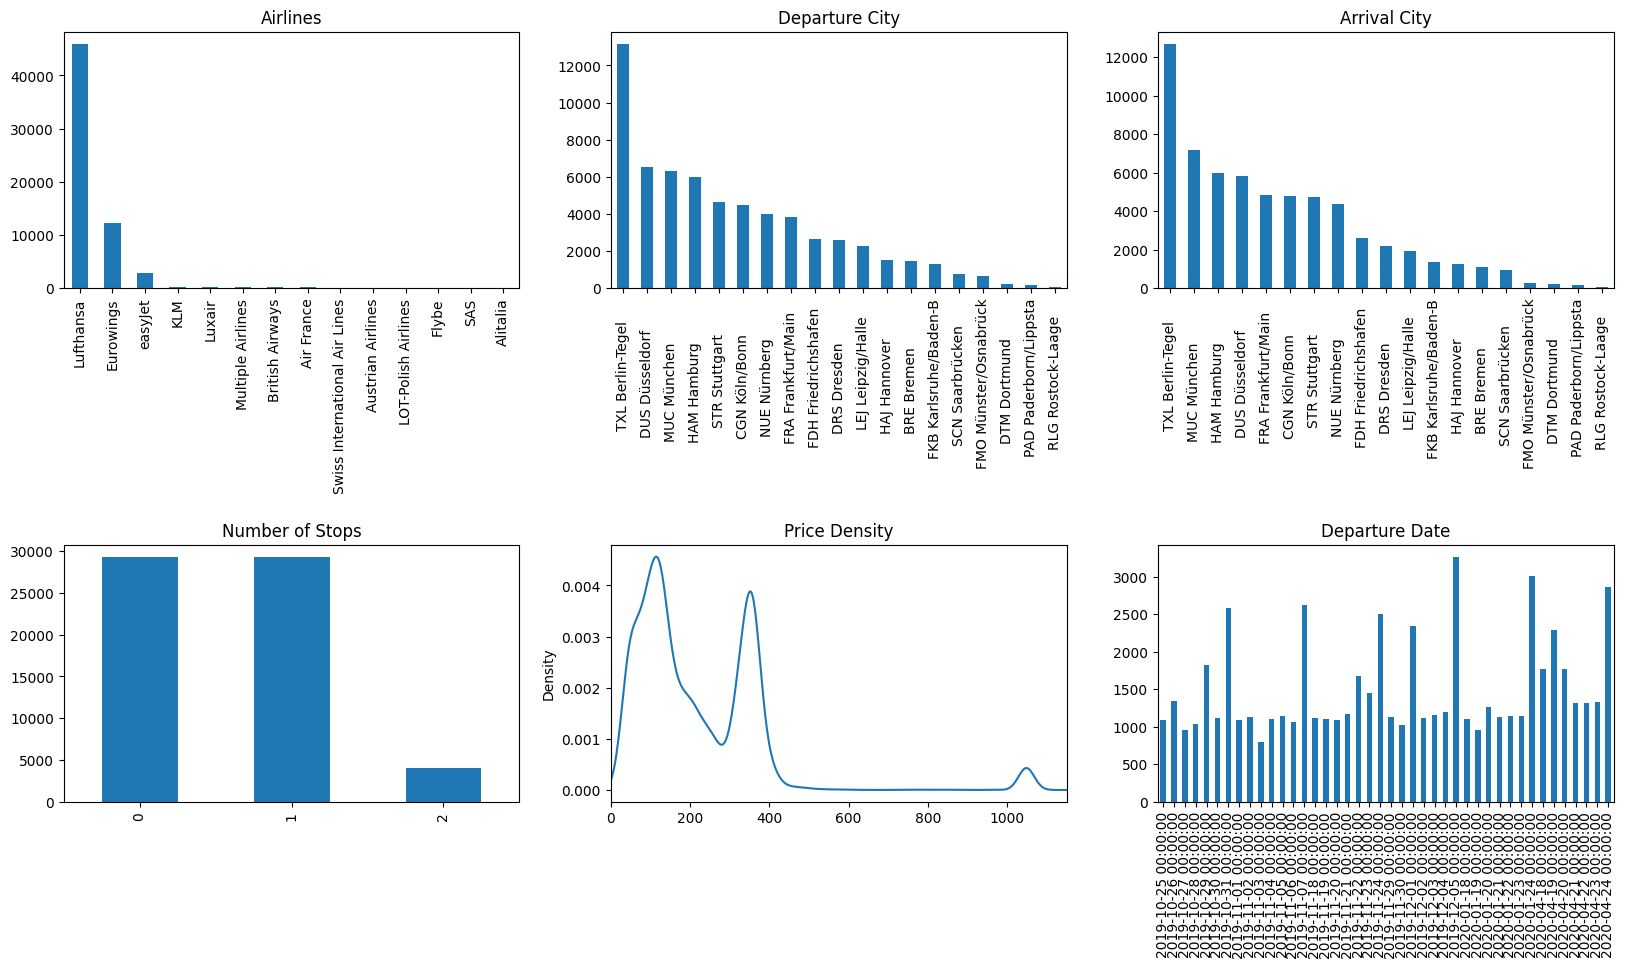

In [321]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

data.airline.value_counts().plot(ax=axes[0,0], kind="bar", xlabel="")
_ = axes[0,0].set_title('Airlines')

data.departure_city.value_counts().plot(ax=axes[0,1], kind="bar", xlabel="")
_ = axes[0,1].set_title('Departure City')

data.arrival_city.value_counts().plot(ax=axes[0,2], kind="bar", xlabel="")
_ = axes[0,2].set_title('Arrival City')

data.stops.value_counts().plot(ax=axes[1,0], kind="bar", xlabel="")
_ = axes[1,0].set_title('Number of Stops')

data.price.plot(ax=axes[1,1], kind="kde", xlabel="", xlim=(0,1150))
_ = axes[1,1].set_title('Price Density')

data.departure_date.value_counts().sort_index().plot(ax=axes[1,2], kind="bar", xlabel="")
_ = axes[1,2].set_title('Departure Date')

plt.subplots_adjust(hspace=1)

### **3.3) Median & Mean Price by Weekday, Month and Departure Date Distance**

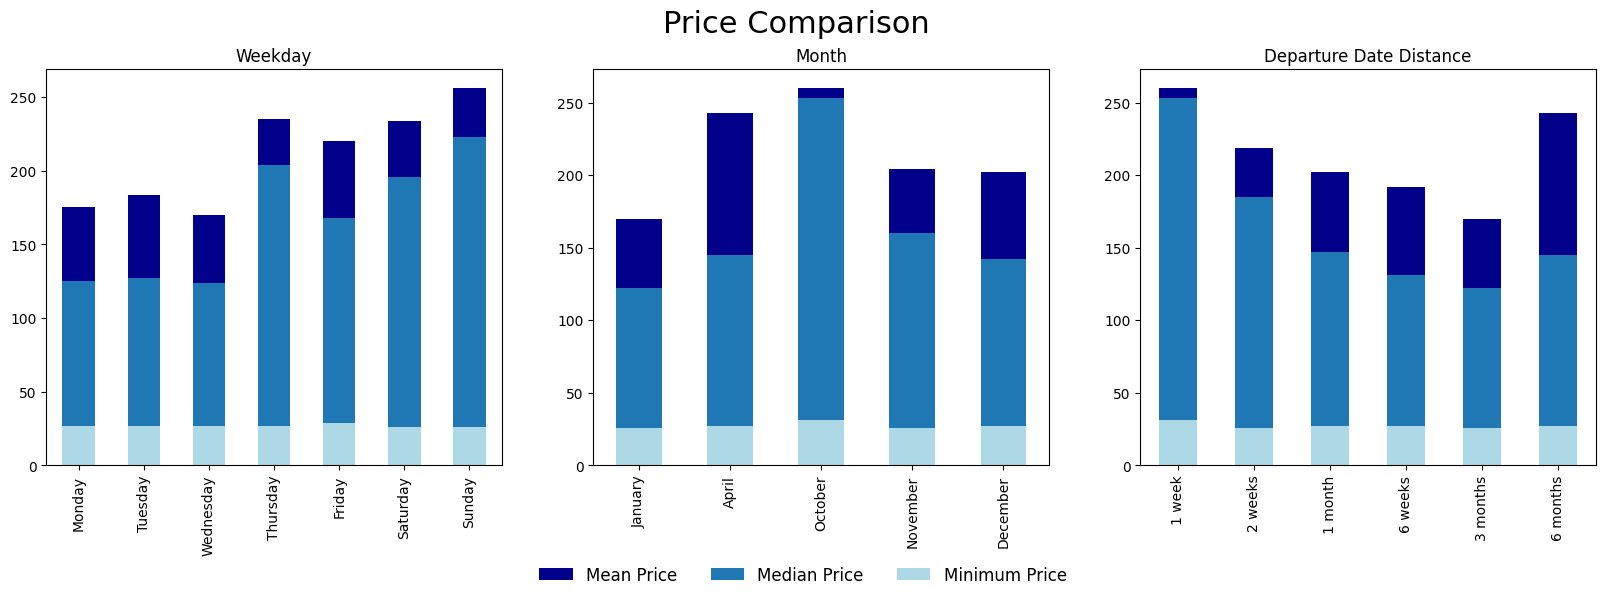

In [307]:
# group by weekday & month & departure date distance
grouped_weekday = data.groupby(data.departure_date.dt.day_name())
grouped_month = data.groupby(data.departure_date.dt.month_name())
grouped_departure_distance = data.groupby(data.departure_date_distance)

# calculate mean and median prices
weekday_mean_price = grouped_weekday.price.mean().reindex(["Monday","Tuesday","Wednesday","Thursday","Friday", "Saturday", "Sunday"])
weekday_median_price = grouped_weekday.price.median().reindex(["Monday","Tuesday","Wednesday","Thursday","Friday", "Saturday", "Sunday"])
weekday_min_price = grouped_weekday.price.min().reindex(["Monday","Tuesday","Wednesday","Thursday","Friday", "Saturday", "Sunday"])

month_mean_price = grouped_month.price.mean().reindex(["January","April","October","November","December"])
month_median_price = grouped_month.price.median().reindex(["January","April","October","November","December"])
month_min_price = grouped_month.price.min().reindex(["January","April","October","November","December"])

departure_distance_mean_price = grouped_departure_distance.price.mean().reindex(["1 week","2 weeks","1 month","6 weeks","3 months", "6 months"])
departure_distance_median_price = grouped_departure_distance.price.median().reindex(["1 week","2 weeks","1 month","6 weeks","3 months", "6 months"])
departure_distance_min_price = grouped_departure_distance.price.min().reindex(["1 week","2 weeks","1 month","6 weeks","3 months", "6 months"])

# plot mean and median prices
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
plt.subplots_adjust(bottom=0.22)

_ = weekday_mean_price.plot(ax=axes[0], xlabel="", kind="bar", color="darkblue")
_ = weekday_median_price.plot(ax=axes[0], xlabel="", kind="bar")
_ = weekday_min_price.plot(ax=axes[0], xlabel="", kind="bar", color="lightblue")
_ = axes[0].set_title('Weekday')

_ = month_mean_price.plot(ax=axes[1], xlabel="", kind="bar", color="darkblue")
_ = month_median_price.plot(ax=axes[1], xlabel="", kind="bar")
_ = month_min_price.plot(ax=axes[1], xlabel="", kind="bar", color="lightblue")
_ = axes[1].set_title('Month')

_ = departure_distance_mean_price.plot(ax=axes[2], xlabel="", kind="bar", color="darkblue")
_ = departure_distance_median_price.plot(ax=axes[2], xlabel="", kind="bar")
_ = departure_distance_min_price.plot(ax=axes[2], xlabel="", kind="bar", color="lightblue")
_ = axes[2].set_title('Departure Date Distance')

_ = fig.suptitle('Price Comparison', fontsize=22)
_ = fig.legend(labels=["Mean Price", "Median Price", "Minimum Price"], loc="lower center", ncol=3, frameon=False, fontsize=12) 

## **4) Train & Test Subsets**

In [340]:
# prepare for subset creation
new_data = data.drop(['scrape_date', 'arrival_time', 'departure_time', 'airline', 'stops', 'departure_date_distance'], axis=1)

# group by date
grouped_date = data.groupby(data.departure_date)

# calculate mean, median, maximum and minimum price for each day
day_mean_price = grouped_date.price.mean().rename('mean_price')
day_median_price = grouped_date.price.median().rename('median_price')
day_min_price = grouped_date.price.min().rename('min_price')
day_max_price = grouped_date.price.max().rename('max_price')

# add mean, median, maximum and minimum price columns to data
new_data = new_data.merge(day_mean_price, on='departure_date')
new_data = new_data.merge(day_median_price, on='departure_date')
new_data = new_data.merge(day_min_price, on='departure_date')
new_data = new_data.merge(day_max_price, on='departure_date')

# divide by months
# divide by weekdays
# divide by departure_date_distance

new_data.head()

,departure_city,arrival_city,departure_date,price,mean_price,median_price,min_price,max_price
0,TXL Berlin-Tegel,DUS Düsseldorf,2019-11-18,33,158.311091,137.0,27,470
1,TXL Berlin-Tegel,DUS Düsseldorf,2019-11-18,33,158.311091,137.0,27,470
2,TXL Berlin-Tegel,DUS Düsseldorf,2019-11-18,33,158.311091,137.0,27,470
3,TXL Berlin-Tegel,DUS Düsseldorf,2019-11-18,37,158.311091,137.0,27,470
4,TXL Berlin-Tegel,DUS Düsseldorf,2019-11-18,37,158.311091,137.0,27,470


## **5) Training of Regression Models**

### **5.1) Linear Regression**

### **5.2) Polynomial Regression**

## **6) Training of Neural Network**

## **7) Comparison of Models**

## **8) Final Thoughts**